In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score

In [14]:
ind_time_filepath = "../output_data_au/Simulation_Results_2023-08-15T100831.821222/individual_time_point_data.csv"
raw_data = "../SampledSAPCRData.xlsx"
hand_labels_filepath = "../Ned Labelling.xlsx"

In [15]:
domain_code_to_name = {"ui_domain" : "Urinary Incontinence Domain",
                      "sf_domain" : "Sexual Function Domain",
                       "uio_domain" : "Urinary Obstruction Domain",
                       "bf_domain" : "Bowel Function Domain",
                       "hf_domain" : "Hormonal Function Domain",
                       "q6d" : "Blood Stools Question"
                      }

In [16]:
ind_time_df = pd.read_csv(ind_time_filepath)
print(len(ind_time_df))
print(ind_time_df.head())

raw_data_df = pd.read_excel(raw_data, sheet_name="PROM-RulesBasedAlgorithmData_R2")
print(len(raw_data_df))
print(raw_data_df.head())

hand_labels_df = pd.read_excel(hand_labels_filepath, sheet_name="Sheet1")
print(len(hand_labels_df))
print(hand_labels_df.head())

16319
  Patient Identifier           Time Point Urinary Incontinence Domain State  \
0  15970_370765.json  2019-04-09 00:00:00                            Normal   
1  15970_413565.json  2020-12-05 00:00:00                          Abnormal   
2   9204_198609.json  2015-05-12 00:00:00                            Normal   
3   9204_235725.json  2015-11-04 00:00:00                            Normal   
4   9204_279366.json  2016-08-29 22:25:00                            Normal   

  Urinary Irritation/Obstruction Domain State Bowel Function Domain State  \
0                     Clinically Urgent Alert                      Normal   
1                     Clinically Urgent Alert                      Normal   
2                                      Normal                      Normal   
3                                      Normal                    Abnormal   
4                     Clinically Urgent Alert                      Normal   

  Q6d State Sexual Function Domain State Hormonal Functi

# Preprocessing

In [17]:
# Link indices together
participant_ids = list(raw_data_df['CapstudiesID'])
report_ids = list(raw_data_df['PROAnswerSetID'])
intervals = list(raw_data_df['Interval'])
idx = {}
for i in range(len(participant_ids)):
    if participant_ids[i] not in idx:
        idx[participant_ids[i]] = [(report_ids[i], intervals[i])]
    else:
        idx[participant_ids[i]] += [(report_ids[i], intervals[i])]

for id in idx:
    for interval in [0, 3, 6, 12, 24, 60]:
        if interval not in [report[1] for report in idx[id]]:
            idx[id].append((None, interval))
    idx[id].sort(key=lambda report: report[1])

In [36]:
sampled_ids = []
for id in idx:
    for report in idx[id]:
        if report[0] != None:
            sampled_ids.append(f"{id}_{report[0]}.json")
sampled_ind_time_df = alert_domains = ind_time_df[ind_time_df['Patient Identifier'].isin(sampled_ids)]

In [18]:
labels = {}
for id in idx:
    hand_label = hand_labels_df.loc[(hand_labels_df['Unnamed: 0'] == id)]
    if len(hand_label) == 0:
        continue
        
    labels[id] = {}
    labels[id]["hand"] = []
    hand_label = list(hand_label.iloc[0])
    col_i = 1
    for i in range(6):
        report_data = []
        for j in range(28):
            report_data.append(list(hand_label)[col_i])
            col_i += 1
        report = {}
        report["UI"] = {"q2": report_data[0], "q3": report_data[1], "q4a": report_data[2], "label": report_data[3], "colour": report_data[4]}
        report["UO"] = {"q4b": report_data[5], "q4c": report_data[6], "q4d": report_data[7], "label": report_data[8], "colour": report_data[9]}
        report["BF"] = {"q6a/6e(max)": report_data[10], "q6b": report_data[11], "q6d": report_data[12], "q7": report_data[13], "label": report_data[14], "colour": report_data[15]}
        report["SF"] = {"q8b": report_data[16], "q9": report_data[17], "q12": report_data[18], "label": report_data[19], "colour": report_data[20]}
        report["HF"] = {"q13a/13b(max)": report_data[21], "q13c": report_data[22], "q13d": report_data[23], "label": report_data[24], "colour": report_data[25]}
        report["Global"] = {"label": report_data[26], "colour": report_data[27]}
        labels[id]["hand"].append(report)
    
    labels[id]["alg"] = []
    for report in idx[id]:
        if report[0] == None:
            labels[id]["alg"].append(None)
            continue
        labels[id]["alg"].append(ind_time_df.loc[(ind_time_df['Patient Identifier'] == f"{id}_{report[0]}.json")].iloc[0])


In [19]:
labels[19622]

{'hand': [{'UI': {'q2': 4,
    'q3': 1,
    'q4a': 1,
    'label': 'Stable',
    'colour': 'Green'},
   'UO': {'q4b': 1, 'q4c': 4, 'q4d': 5, 'label': 'Urgent', 'colour': 'Red'},
   'BF': {'q6a/6e(max)': 1,
    'q6b': 1,
    'q6d': 1,
    'q7': 1,
    'label': 'Stable',
    'colour': 'Green'},
   'SF': {'q8b': 4, 'q9': 3, 'q12': 1, 'label': 'Stable', 'colour': 'Green'},
   'HF': {'q13a/13b(max)': 1,
    'q13c': 1,
    'q13d': 3,
    'label': 'Mild',
    'colour': 'Yellow'},
   'Global': {'label': 'Urgent', 'colour': 'Red'}},
  {'UI': {'q2': 3, 'q3': 1, 'q4a': 2, 'label': nan, 'colour': nan},
   'UO': {'q4b': 1, 'q4c': 1, 'q4d': 2, 'label': 'Mild', 'colour': 'Yellow'},
   'BF': {'q6a/6e(max)': 1,
    'q6b': 1,
    'q6d': 1,
    'q7': 1,
    'label': 'Stable',
    'colour': 'Green'},
   'SF': {'q8b': 3,
    'q9': 3,
    'q12': 4,
    'label': 'Moderate',
    'colour': 'Orange'},
   'HF': {'q13a/13b(max)': 1,
    'q13c': 1,
    'q13d': 2,
    'label': 'Mild',
    'colour': 'Yellow'},
   'G

# Accuracy

In [55]:
def hand_label_conversion(hand_label):
    if hand_label == "Stable":
        return "Normal"
    elif hand_label == "Mild":
        return "Abnormal"
    elif hand_label == "Moderate" or hand_label == "Urgent":
        return "Clinically Urgent Alert"
    else:
        return ""

def is_same_label(alg_label, hand_label):
    return alg_label == hand_label_conversion(hand_label)

In [21]:
total_labels = 0
accurate_labels = 0
hand_labels = []
alg_labels = []
for id in labels:
    for i in range(6):
        hand_label = labels[id]["hand"][i]["Global"]["label"]
        if isinstance(labels[id]["alg"][i], type(None)) or (hand_label not in ["Stable", "Mild", "Moderate", "Urgent"]):
            continue
        total_labels += 1
        alg_label = labels[id]["alg"][i]["Final Alert State"]
        if is_same_label(alg_label, hand_label):
            accurate_labels += 1
        hand_labels.append(hand_label_conversion(hand_label))
        alg_labels.append(alg_label)


In [22]:
print(total_labels)
print(accurate_labels)

407
235


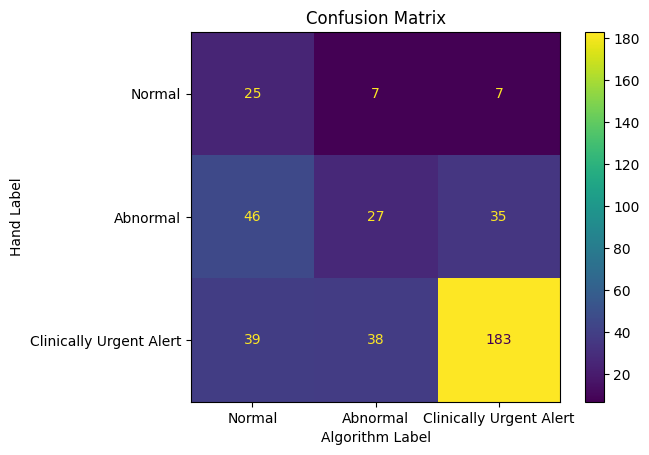

In [23]:
cm = confusion_matrix(hand_labels, alg_labels, labels=["Normal", "Abnormal", "Clinically Urgent Alert"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Abnormal", "Clinically Urgent Alert"])
disp.plot()
plt.title("Confusion Matrix")
plt.xlabel("Algorithm Label")
plt.ylabel("Hand Label")
plt.show()

In [108]:
cohen_kappa_score(hand_labels, alg_labels)

0.2637590315829328

# Label Distribution Breakdown

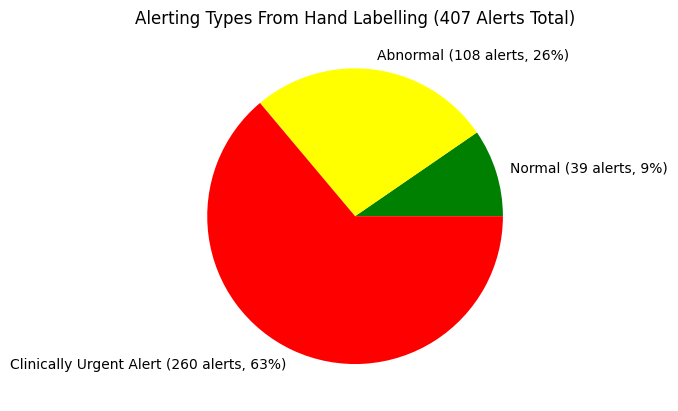

In [43]:
# Look at the frequency of alert types from hand labelling
alert_types = ["Normal", "Abnormal", "Clinically Urgent Alert"]
alert_counts = [(alert,hand_labels.count(alert)) for alert in alert_types]
plt.pie([alert[1] for alert in alert_counts], labels = [f"{alert[0]} ({alert[1]} alerts, {int(100*alert[1]/total_labels)}%)" for alert in alert_counts], colors=["green","yellow","red"]
)
plt.title(f"Alerting Types From Hand Labelling ({total_labels} Alerts Total)")
plt.show()

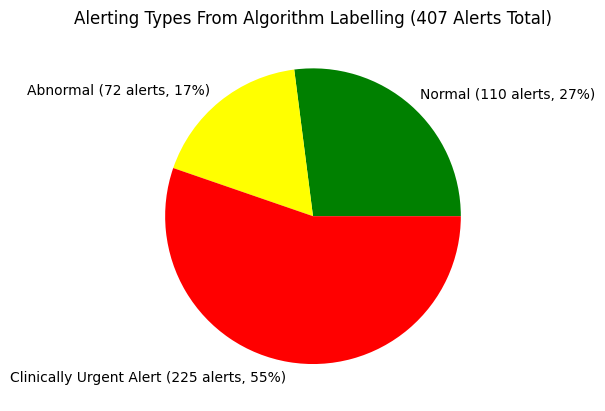

In [44]:
# Look at the frequency of alert types from hand labelling
alert_types = ["Normal", "Abnormal", "Clinically Urgent Alert"]
alert_counts = [(alert, alg_labels.count(alert)) for alert in alert_types]
plt.pie([alert[1] for alert in alert_counts], labels = [f"{alert[0]} ({alert[1]} alerts, {int(100*alert[1]/total_labels)}%)" for alert in alert_counts], colors=["green","yellow","red"])
plt.title(f"Alerting Types From Algorithm Labelling ({total_labels} Alerts Total)")
plt.show()

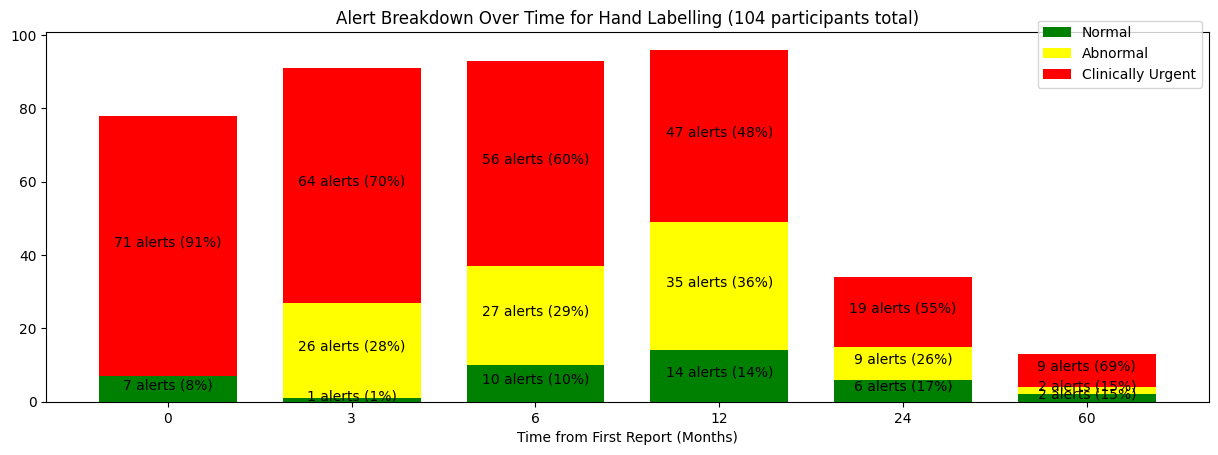

In [103]:
date_points = ["0", "3", "6", "12", "24", "60"] # measured in months
# Alerts by report number
alert_types = [hand_label_conversion(report['Global']['label']) for participant in labels for report in labels[participant]['hand']] # list(labels['Final Alert State'])
alert_times = [report_i for participant in labels for report_i in range(len(labels[participant]['hand']))]
patient_ids = [participant for participant in labels for report in labels[participant]['hand']]
alerts_by_patient = {} # {id : [(datetime, alert_type)]}

for i in range(len(alert_types)):
    patient_id = patient_ids[i]
    time = alert_times[i]
    if patient_id not in alerts_by_patient:
        alerts_by_patient[patient_id] = [(time, alert_types[i])]
    else:
        alerts_by_patient[patient_id].append((time, alert_types[i]))
        
alert_counts = zip(date_points, [{"Normal": 0, "Abnormal": 0, "Clinically Urgent Alert": 0} for date in date_points])
alert_counts = dict(alert_counts)

for patient_id in alerts_by_patient.keys():
    alerts_by_patient[patient_id].sort(key=lambda alert: alert[0])
    alerts_by_patient[patient_id] = [(i, alerts_by_patient[patient_id][i][1]) for i in range(len(alerts_by_patient[patient_id]))]    
    sorted_alerts = alerts_by_patient[patient_id]
    for i in range(len(sorted_alerts)):
        if (i == 0 and sorted_alerts[i][1] == "Abnormal") or sorted_alerts[i][1] == "":
            continue 
        alert_counts[date_points[i]][sorted_alerts[i][1]] += 1

# alert_counts["6-12"] = {}
# alert_counts["24-60"] = {}
# for alert in ["Normal", "Abnormal", "Clinically Urgent Alert"]:
#     alert_counts["6-12"][alert] = alert_counts["6"][alert] + alert_counts["12"][alert]
#     alert_counts["24-60"][alert] = alert_counts["24"][alert] + alert_counts["60"][alert]

# date_points = ["0", "3", "6-12", "24-60"] # measured in months

old_counts = alert_counts
hand_alert_counts = {
    "Normal": np.array([old_counts[date]["Normal"] for date in date_points]),
    "Abnormal": np.array([old_counts[date]["Abnormal"] for date in date_points]),
    "Clinically Urgent": np.array([old_counts[date]["Clinically Urgent Alert"] for date in date_points]),
}
total_participant_count = len(alerts_by_patient.keys())
alert_colors = {
    "Normal": "green",
    "Abnormal": "yellow",
    "Clinically Urgent": "red",
}
width = 0.75

fig, ax = plt.subplots()
# fig.set_figheight(15)
fig.set_figwidth(15)
bottom = np.zeros(len(date_points))

# Stacked bars
for alert_type, alert_count in hand_alert_counts.items():
    p = ax.bar(date_points, alert_count, width, label=alert_type, bottom=bottom, color = alert_colors[alert_type])
    bottom += alert_count

total_alert_counts = [hand_alert_counts["Normal"][date_i] + hand_alert_counts["Abnormal"][date_i] + hand_alert_counts["Clinically Urgent"][date_i] for date_i in range(len(date_points))]

# Patch Labels
for i in range(len(ax.patches)):
    bar = ax.patches[i]
    if bar.get_height() == 0:
        continue
    ax.text(bar.get_x() + bar.get_width() / 2,
      bar.get_height() / 2 + bar.get_y(),
      f"{round(bar.get_height())} alerts ({int(100*round(bar.get_height())/total_alert_counts[i%len(date_points)])}%)", ha = 'center',
      color = 'black', size = 10)
    
ax.set_title(f"Alert Breakdown Over Time for Hand Labelling ({total_participant_count} participants total)")
ax.legend(bbox_to_anchor=(1, 1.05))
plt.xlabel("Time from First Report (Months)")

plt.show()


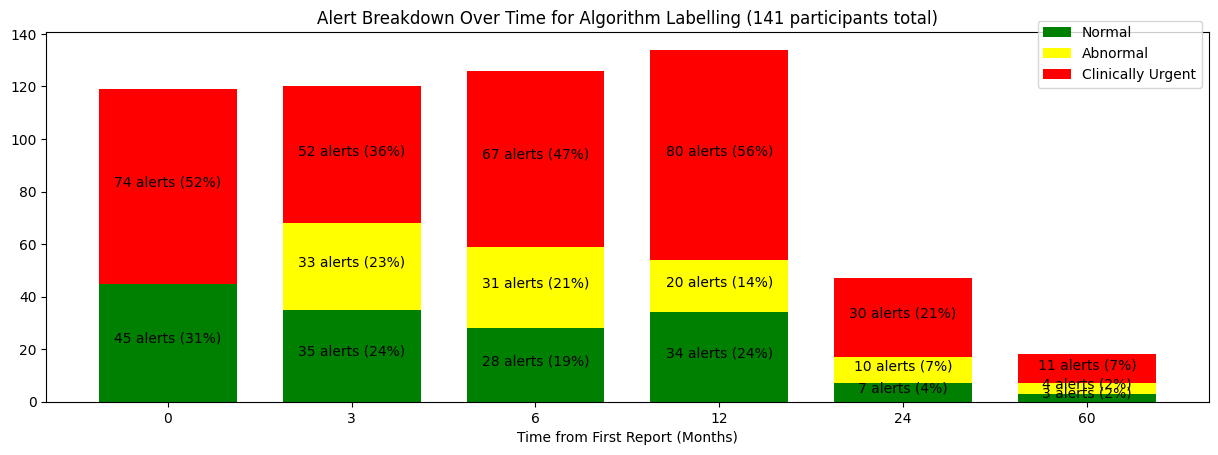

In [105]:
date_points = ["0", "3", "6", "12", "24", "60"] # measured in months
# Alerts by report number
alert_types = list(sampled_ind_time_df['Final Alert State'])
patient_ids = list(sampled_ind_time_df['Patient Identifier'])
alert_times = []
for id in patient_ids:
    pid = id.split('_')[0]
    rid = id.split('_')[1][:-5]
    interval = list(raw_data_df[(raw_data_df['CapstudiesID']== int(pid)) & (raw_data_df['PROAnswerSetID']== int(rid))]["Interval"])[0]
    alert_times.append(interval)
alerts_by_patient = {} # {id : [(datetime, alert_type)]}

for i in range(len(alert_types)):
    patient_id = patient_ids[i].split('_')[0]
    time = alert_times[i]
    if patient_id not in alerts_by_patient:
        alerts_by_patient[patient_id] = [(time, alert_types[i])]
    else:
        alerts_by_patient[patient_id].append((time, alert_types[i]))
        
alert_counts = zip(date_points, [{"Normal": 0, "Abnormal": 0, "Clinically Urgent Alert": 0} for date in date_points])
alert_counts = dict(alert_counts)

for patient_id in alerts_by_patient.keys():
    for date in date_points:
        if int(date) not in [alert[0] for alert in alerts_by_patient[patient_id]]:
            alerts_by_patient[patient_id].append((int(date), ""))
        
    alerts_by_patient[patient_id].sort(key=lambda alert: alert[0])
    alerts_by_patient[patient_id] = [(i, alerts_by_patient[patient_id][i][1]) for i in range(len(alerts_by_patient[patient_id]))]    
    sorted_alerts = alerts_by_patient[patient_id]
    for i in range(len(sorted_alerts)):
        if (i == 0 and sorted_alerts[i][1] == "Abnormal") or sorted_alerts[i][1] == "":
            continue
        alert_counts[date_points[i]][sorted_alerts[i][1]] += 1

old_counts = alert_counts
alg_alert_counts = {
    "Normal": np.array([old_counts[date]["Normal"] for date in date_points]),
    "Abnormal": np.array([old_counts[date]["Abnormal"] for date in date_points]),
    "Clinically Urgent": np.array([old_counts[date]["Clinically Urgent Alert"] for date in date_points]),
}
total_participant_count = len(alerts_by_patient.keys())
alert_colors = {
    "Normal": "green",
    "Abnormal": "yellow",
    "Clinically Urgent": "red",
}
width = 0.75

fig, ax = plt.subplots()
# fig.set_figheight(15)
fig.set_figwidth(15)
bottom = np.zeros(len(date_points))

# Stacked bars
for alert_type, alert_count in alg_alert_counts.items():
    p = ax.bar(date_points, alert_count, width, label=alert_type, bottom=bottom, color = alert_colors[alert_type])
    bottom += alert_count

# Patch Labels
for i in range(len(ax.patches)):
    bar = ax.patches[i]
    if bar.get_height() == 0:
        continue
    ax.text(bar.get_x() + bar.get_width() / 2,
      bar.get_height() / 2 + bar.get_y(),
      f"{round(bar.get_height())} alerts ({int(100*round(bar.get_height())/total_participant_count)}%)", ha = 'center',
      color = 'black', size = 10)
    
ax.set_title(f"Alert Breakdown Over Time for Algorithm Labelling ({total_participant_count} participants total)")
ax.legend(bbox_to_anchor=(1, 1.05))
plt.xlabel("Time from First Report (Months)")

plt.show()


# Chi-Square Test

In [106]:
from scipy.stats import chi2_contingency
exp_alert_counts = hand_alert_counts
alert_counts = alg_alert_counts
    
for report_no in range(0, 6):
    f_exp = []
    f_obs = []
    if report_no == 0:
        f_exp = np.array([exp_alert_counts["Normal"][report_no],
                      exp_alert_counts["Clinically Urgent"][report_no]])
        f_obs = np.array([alert_counts["Normal"][report_no],
                      alert_counts["Clinically Urgent"][report_no]]) 
    else: 
        f_exp = np.array([exp_alert_counts["Normal"][report_no],
                          exp_alert_counts["Abnormal"][report_no],
                          exp_alert_counts["Clinically Urgent"][report_no]])
        f_obs = np.array([alert_counts["Normal"][report_no],
                          alert_counts["Abnormal"][report_no],
                          alert_counts["Clinically Urgent"][report_no]]) 
    stat, p, dof, expected = chi2_contingency([f_exp, f_obs])
    print(f"report{report_no}: stat={stat},p={p}")
print()

report0: stat=18.71490331033454,p=1.517914780506174e-05
report1: stat=30.778623943458108,p=2.0725581783826116e-07
report2: stat=4.925145046297703,p=0.08521545003490417
report3: stat=15.133891302405893,p=0.000517269961132827
report4: stat=0.5260733977456951,p=0.7687136858676856
report5: stat=0.2671652421652422,p=0.8749551762472996

